# **Partie 1: Detection de visages avec Viola & Jones**

**A- Preparation des donnees**

In [ ]:

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


img = "/content/drive/MyDrive/ComputerVision/pasta"


In [ ]:

image_files = [os.path.join(img, file) for file in os.listdir(img) if file.endswith('.jpg')]


Total TP: 12, Total FP: 0, Total FN: 18


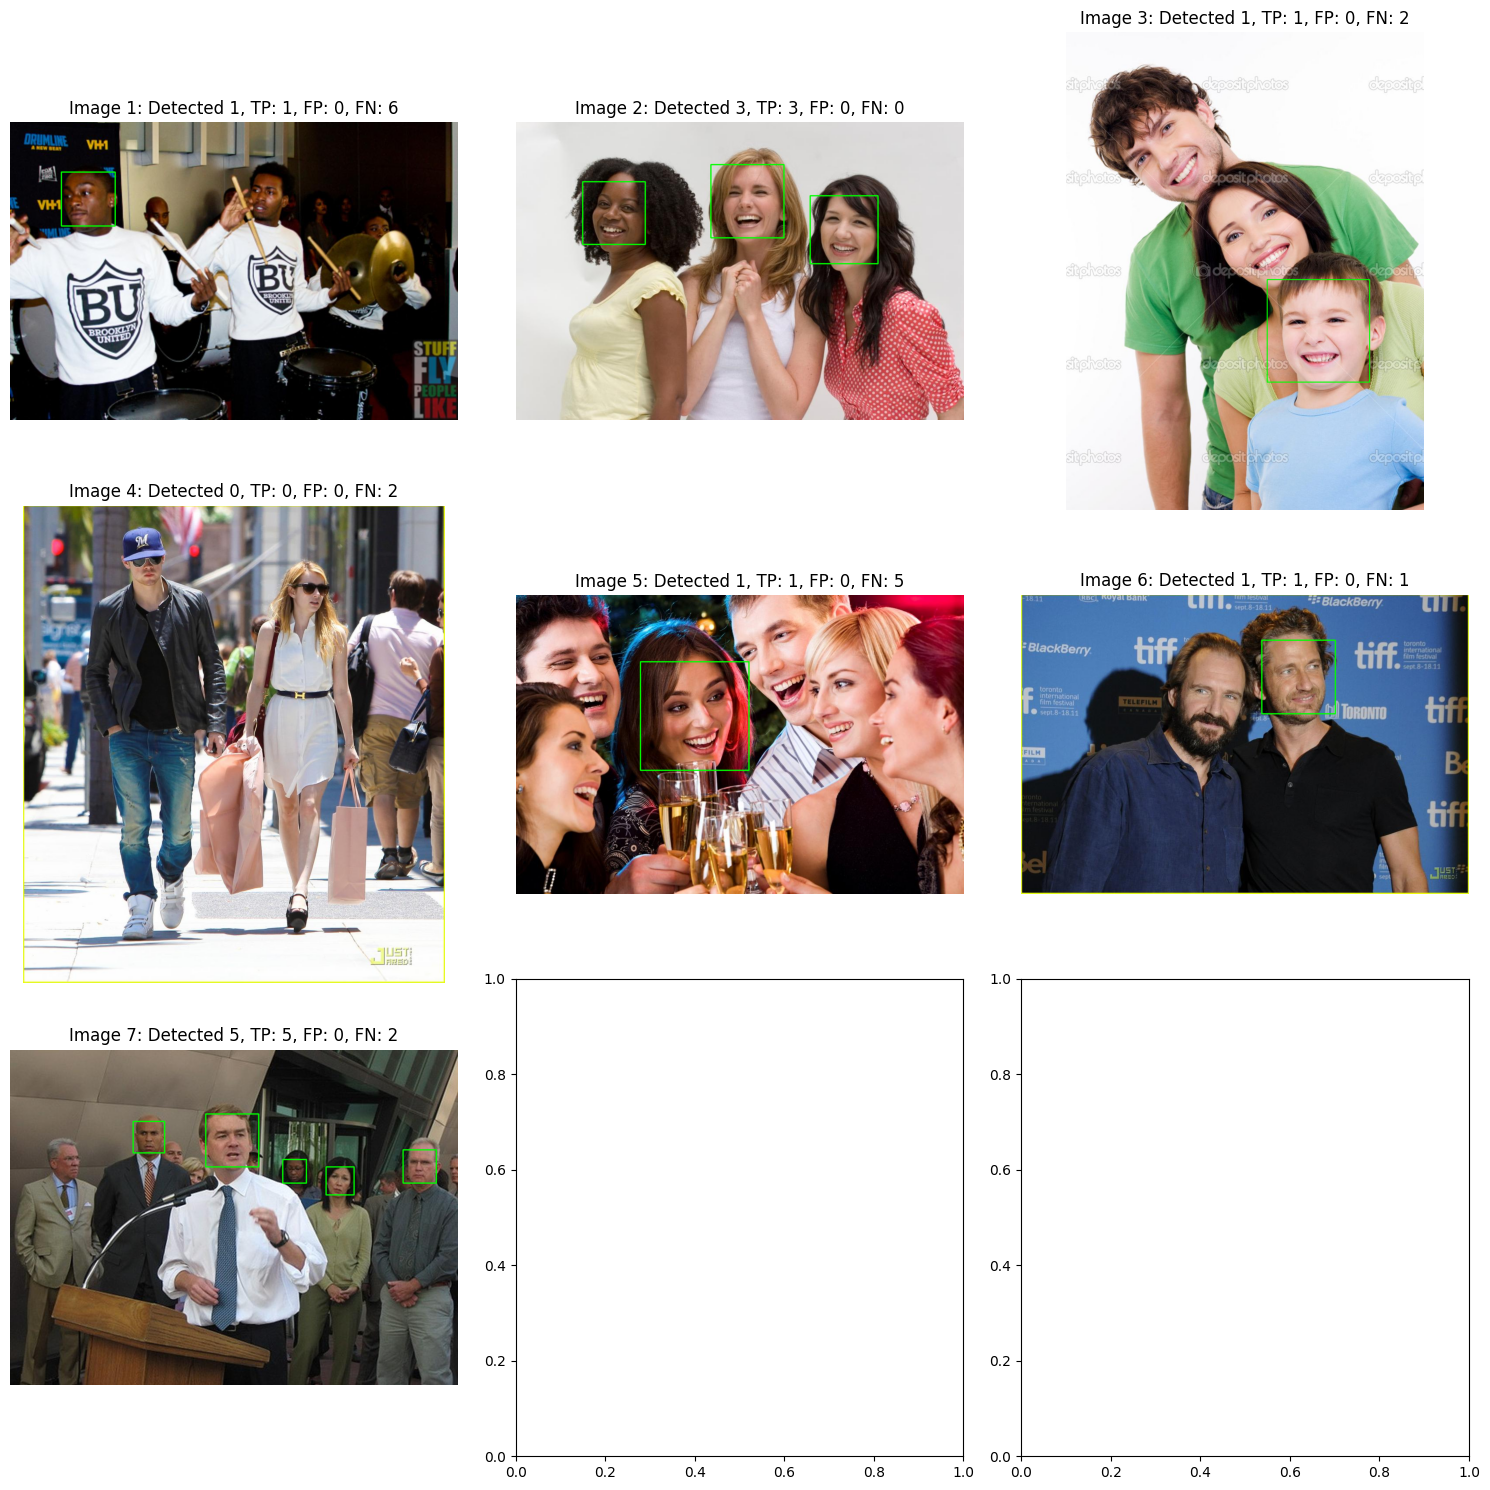

In [ ]:

import cv2
import os
import matplotlib.pyplot as plt

# Chemin vers le répertoire contenant les images
directory = "/content/drive/MyDrive/ComputerVision/pasta"

# Liste pour stocker les chemins des fichiers d'images
image_files = []

# Estimation du nombre de visages par image
estimated_faces = {
    '1.jpg': 2,
    '2.jpg': 7,
    '3.jpg': 3,
    '4.jpg': 7,  # Assurez-vous que le nombre ici est correct
    '5.jpg': 2,
    '6.jpg': 3,
    '7.jpg': 6,
    '8.jpg': 8,
}

# Recherche des fichiers d'images dans le répertoire
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        image_files.append(os.path.join(directory, filename))

# Initialiser le classificateur de visages
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Compteurs pour les métriques totales
total_TP = 0
total_FP = 0
total_FN = 0

# Préparation de la visualisation
fig, axes = plt.subplots((len(image_files) + 2) // 3, 3, figsize=(15, 5 * ((len(image_files) + 2) // 3)))
axes = axes.flatten()

# Traitement des images
for idx, image_path in enumerate(image_files):
    image = cv2.imread(image_path)
    basename = os.path.basename(image_path)
    if image is not None:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.15, minNeighbors=15, minSize=(30, 30))

        detected_faces = len(faces)
        expected_faces = estimated_faces.get(basename, 0)
        TP = min(detected_faces, expected_faces)
        FP = detected_faces - TP
        FN = max(0, expected_faces - detected_faces)

        # Mise à jour des compteurs totaux
        total_TP += TP
        total_FP += FP
        total_FN += FN

        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        ax = axes[idx]
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Image {idx+1}: Detected {detected_faces}, TP: {TP}, FP: {FP}, FN: {FN}")
        ax.axis('off')
    else:
        print(f"Failed to load image: {image_path}")

# Affichage des totaux avant de montrer les images
print(f"Total TP: {total_TP}, Total FP: {total_FP}, Total FN: {total_FN}")

plt.tight_layout()
plt.show()


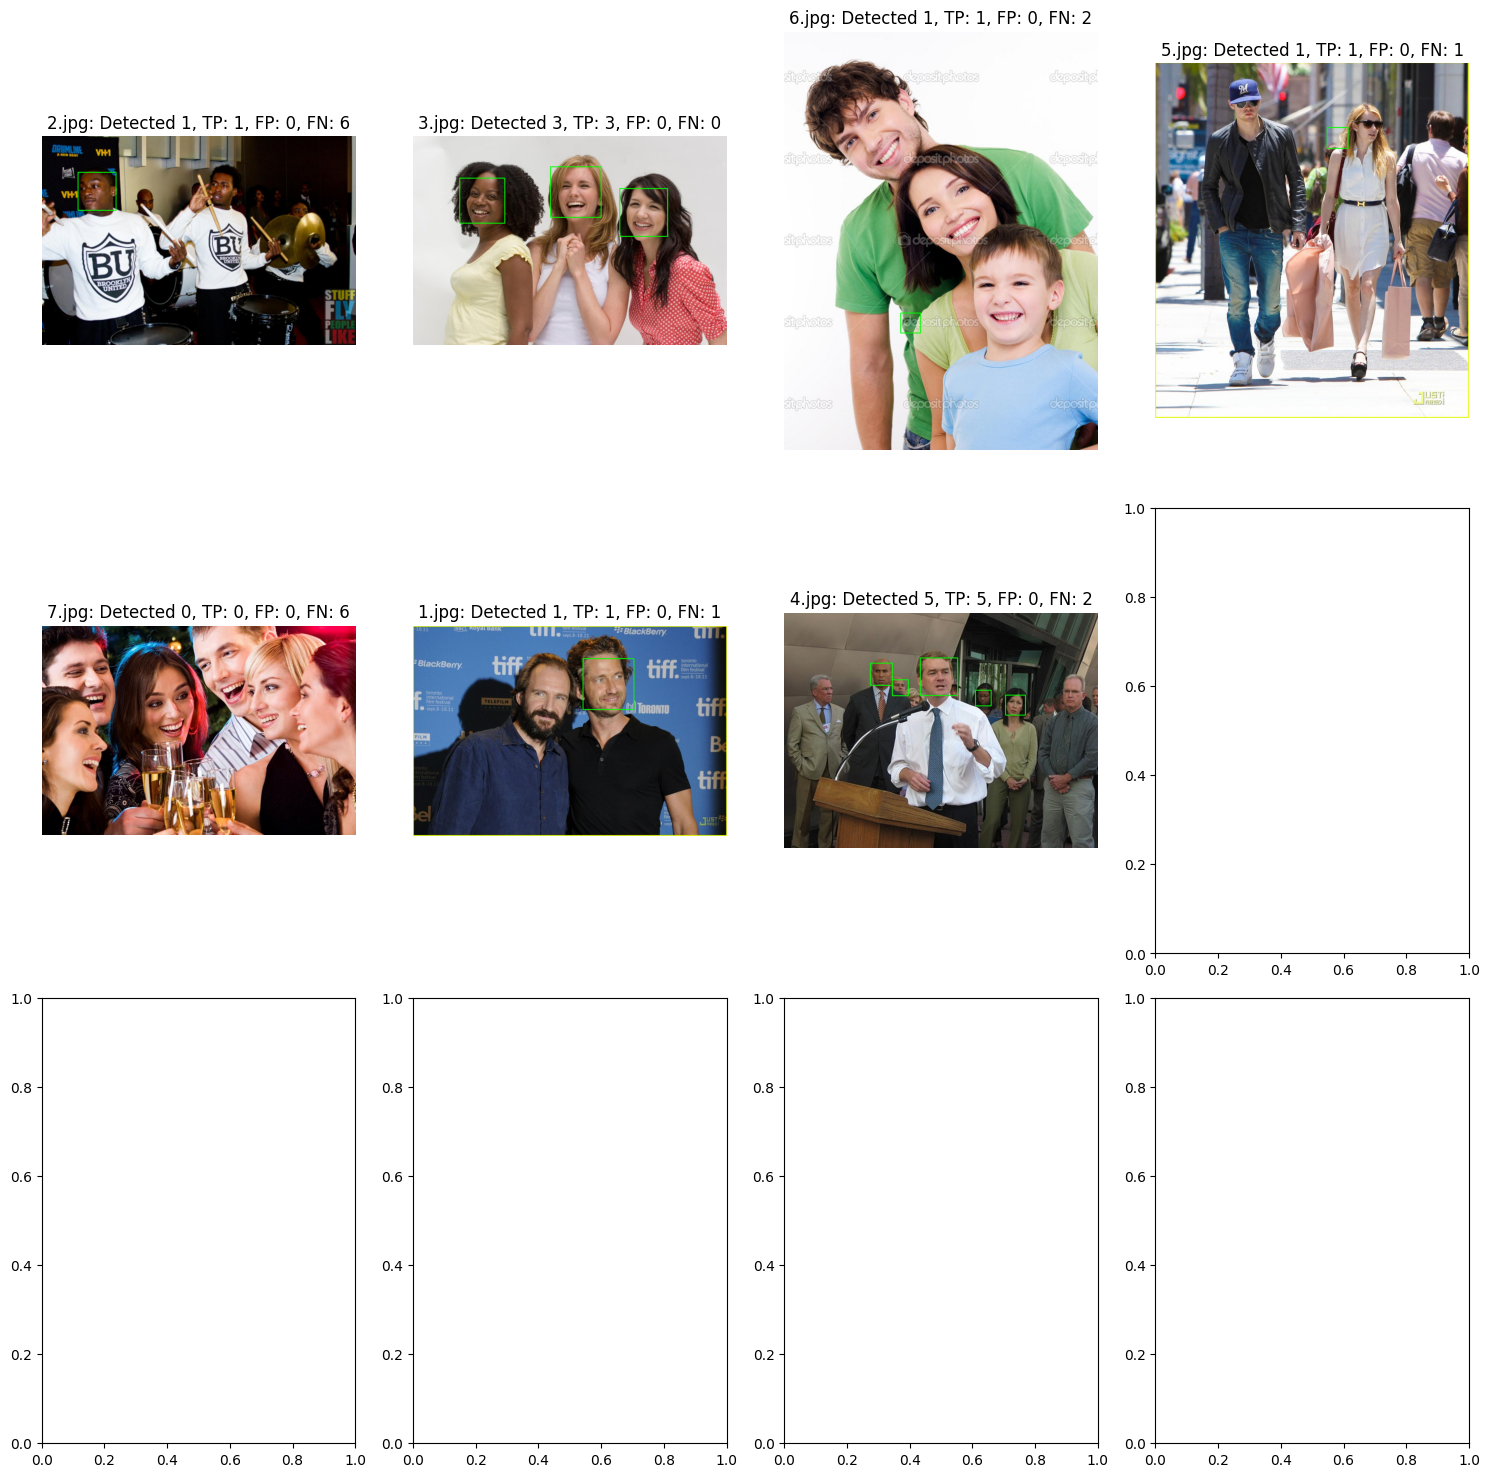

Total TP: 12, Total FP: 0, Total FN: 18


In [ ]:




import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def sliding_window(image, stepSize, windowSize):
    """ Génère des fenêtres glissantes sur l'image. """
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def non_max_suppression_fast(boxes, overlapThresh):
    """ Effectue la Non-Maximum Suppression (NMS) sur une liste de boîtes. """
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in range(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)
    return boxes[pick].astype("int")

def detect_faces_with_sliding_window(image, face_cascade, windowSize, overlap_ratio):
    stepSize = int(windowSize[0] * (1 - overlap_ratio))
    detected_faces = []
    for (x, y, window) in sliding_window(image, stepSize, windowSize):
        if window.shape[0] != windowSize[1] or window.shape[1] != windowSize[0]:
            continue
        faces = face_cascade.detectMultiScale(window, scaleFactor=1.3, minNeighbors=7, minSize=(30, 30))
        for (fx, fy, fw, fh) in faces:
            detected_faces.append([x + fx, y + fy, fw, fh])
    detected_faces = np.array(detected_faces)
    return non_max_suppression_fast(detected_faces, 0.5)

directory = "/content/drive/MyDrive/ComputerVision/pasta"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
windowSize = (300, 300)
overlap_ratio = 0.65

# Métriques globales
total_TP = 0
total_FP = 0
total_FN = 0

fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.flatten()

for idx, filename in enumerate(os.listdir(directory)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path)
        if image is None:
            continue
        detected_faces = detect_faces_with_sliding_window(image, face_cascade, windowSize, overlap_ratio)
        expected_count = estimated_faces.get(filename, 0)
        detected_count = len(detected_faces)
        TP = min(detected_count, expected_count)
        FP = detected_count - TP
        FN = max(0, expected_count - detected_count)
        total_TP += TP
        total_FP += FP
        total_FN += FN
        for (x, y, w, h) in detected_faces:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        if idx < len(axes):
            axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f"{filename}: Detected {detected_count}, TP: {TP}, FP: {FP}, FN: {FN}")
            axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"Total TP: {total_TP}, Total FP: {total_FP}, Total FN: {total_FN}")

